In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

C:\Users\RobertAlonso\Anaconda3\envs\kaggle\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Jobs

In [4]:
root_dir = '../../_data/'
df_jobs = pd.read_json(root_dir + 'laborum.jl', encoding='latin-1', lines=True)
df_jobs = df_jobs.drop_duplicates(['post_url'])
df_jobs = df_jobs.reset_index(drop=True)
df_jobs = pd.DataFrame(df_jobs[['company_name', 'company_type', 'job_description', 'job_function', 'job_position', 'job_requirements']])

In [5]:
def merge(row):
    job_function = " ".join(row['job_function']) if row['job_function'] is not np.nan else ""
    job_requirements = " ".join(row['job_requirements']) if row['job_requirements'] is not np.nan else ""
    return " ".join([row['company_type'], row['job_description'], job_function, \
                    row['job_position'], job_requirements])
    
df_jobs['merged_description'] = df_jobs.apply(merge, axis=1)

In [26]:
sp_stopwords = set(stopwords.words('spanish'))
def preprocess(x):
    x = re.sub('[\n\r\t/]', ' ', x)
    x = re.sub('[{0}]'.format(re.escape("%0123456789&+@#,_–°´¡!-()=<>.:;?|'“”’*·•\"")), ' ', x)
    x = re.sub('[{0}]'.format(re.escape("$%()+0123456789;=?")), ' ', x)
    x = x.lower()
    return ' '.join([unidecode(w) for w in x.split() \
                     if len(w) > 2 and w not in sp_stopwords])

In [16]:
df_jobs['preprocessed'] = df_jobs['merged_description'].apply(preprocess)

In [159]:
df_jobs.to_csv(root_dir + 'laborum_preprocessed.csv', index=False)

## Profiles

In [6]:
root_dir = '../../_data/'

In [7]:
df_profiles = pd.read_json(root_dir + 'dump_100K.jl', encoding='latin-1', lines=True)
df_profiles = df_profiles.drop_duplicates(['canonical_url'])
df_profiles = df_profiles.reset_index(drop=True)

In [155]:
df_profiles = df_profiles[['full_name', 'headline', 'summary', 'education', 'experience', \
         'industry', 'languages', 'skills']]

In [156]:
def merge(row):
    education = ' '.join([' '.join(item.get('degrees', [])) \
                    for item in row['education']]) if row['education'] is not np.nan else ''
    experience = ' '.join([item.get('description', '') \
                    for item in row['experience']]) if row['experience'] is not np.nan else ''
    languages = ' '.join([' '.join(item.values()) \
                    for item in row['languages']] if row['languages'] is not np.nan else '')
    skills = ' '.join(row['skills']) if row['skills'] is not np.nan else ''
    full_name = row['full_name'] if row['full_name'] is not np.nan else ''
    headline = row['headline'] if row['headline'] is not np.nan else ''
    summary = row['summary'] if row['summary'] is not np.nan else ''
    industry = row['industry'] if row['industry'] is not np.nan else ''
    return ' '.join([headline, summary, industry, education, experience, \
                     languages, skills])
    
df_profiles['merged_description'] = df_profiles.apply(merge, axis=1)

In [157]:
df_profiles['preprocessed'] = df_profiles['merged_description'].apply(preprocess)

In [158]:
df_profiles.to_csv(root_dir + 'dump_100k_preprocessed.csv', index=False)

## Checkpoint

In [9]:
df_jobs = pd.read_csv(root_dir + 'laborum_preprocessed.csv', encoding='latin-1')
df_jobs.shape

(3256, 8)

In [10]:
df_profiles = pd.read_csv(root_dir + 'dump_100k_preprocessed.csv', encoding='latin-1')
df_profiles.shape

(99997, 10)

In [10]:
df_profiles = df_profiles[df_profiles['merged_description'].apply(lambda x: len(x)>200)]

## Doc2Vec

In [9]:
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [14]:
df = pd.DataFrame()
df['document'] = pd.concat((df_jobs['preprocessed'], df_profiles['preprocessed'])) \
                    .reset_index(drop=True)

In [15]:
df['label'] = pd.concat((pd.Series(df_jobs.index).apply(lambda x: 'Job-' + str(x)), \
                         pd.Series(df_profiles.index).apply(lambda x: 'Profile-' + str(x)))) \
                .reset_index(drop=True)

In [175]:
model = Doc2Vec([LabeledSentence(document.split(), [label]) for document, label in zip(df['document'], df['label'])],
                 min_count=1, window=10, sample=1e-4, negative=5, iter=20)

2017-11-23 20:30:59,238 : INFO : collecting all words and their counts
2017-11-23 20:30:59,240 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-11-23 20:30:59,675 : INFO : PROGRESS: at example #10000, processed 1543846 words (3565847/s), 48700 word types, 10000 tags
2017-11-23 20:31:00,064 : INFO : PROGRESS: at example #20000, processed 2886284 words (3462431/s), 75705 word types, 20000 tags
2017-11-23 20:31:00,419 : INFO : collected 94393 word types and 28785 unique tags from a corpus of 28785 examples and 4125529 words
2017-11-23 20:31:00,420 : INFO : Loading a fresh vocabulary
2017-11-23 20:31:01,079 : INFO : min_count=1 retains 94393 unique words (100% of original 94393, drops 0)
2017-11-23 20:31:01,080 : INFO : min_count=1 leaves 4125529 word corpus (100% of original 4125529, drops 0)
2017-11-23 20:31:01,411 : INFO : deleting the raw counts dictionary of 94393 items
2017-11-23 20:31:01,417 : INFO : sample=0.0001 downsamples 674 most-common words

2017-11-23 20:32:11,746 : INFO : PROGRESS: at 39.10% examples, 316368 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:12,759 : INFO : PROGRESS: at 39.63% examples, 315852 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:13,760 : INFO : PROGRESS: at 40.17% examples, 315887 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:14,782 : INFO : PROGRESS: at 40.70% examples, 316327 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:15,821 : INFO : PROGRESS: at 41.25% examples, 315948 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:16,821 : INFO : PROGRESS: at 41.67% examples, 314620 words/s, in_qsize 6, out_qsize 0
2017-11-23 20:32:17,828 : INFO : PROGRESS: at 42.14% examples, 313635 words/s, in_qsize 6, out_qsize 0
2017-11-23 20:32:18,838 : INFO : PROGRESS: at 42.70% examples, 313382 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:19,847 : INFO : PROGRESS: at 43.25% examples, 312969 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:32:20,870 : INFO : PROGRESS: at 43.78% examples, 312427 wor

2017-11-23 20:33:33,274 : INFO : PROGRESS: at 81.60% examples, 301196 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:34,287 : INFO : PROGRESS: at 82.31% examples, 301670 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:35,289 : INFO : PROGRESS: at 83.06% examples, 302255 words/s, in_qsize 6, out_qsize 0
2017-11-23 20:33:36,292 : INFO : PROGRESS: at 83.69% examples, 302435 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:37,318 : INFO : PROGRESS: at 84.00% examples, 301495 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:38,336 : INFO : PROGRESS: at 84.79% examples, 302299 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:39,338 : INFO : PROGRESS: at 85.49% examples, 303277 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:40,361 : INFO : PROGRESS: at 86.25% examples, 304052 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:41,362 : INFO : PROGRESS: at 87.04% examples, 304764 words/s, in_qsize 5, out_qsize 0
2017-11-23 20:33:42,375 : INFO : PROGRESS: at 87.68% examples, 304900 wor

In [176]:
model.save('Doc2Vec_jobs+profiles')

2017-11-23 20:34:53,831 : INFO : saving Doc2Vec object under Doc2Vec_jobs+profiles, separately None
2017-11-23 20:34:53,834 : INFO : not storing attribute syn0norm
2017-11-23 20:34:53,837 : INFO : not storing attribute cum_table
2017-11-23 20:34:55,481 : INFO : saved Doc2Vec_jobs+profiles


In [17]:
model = gensim.models.Doc2Vec.load('../../_data/Doc2Vec_jobs+profiles')

2017-11-24 02:20:30,213 : INFO : loading Doc2Vec object from ../../_data/Doc2Vec_jobs+profiles
2017-11-24 02:20:31,413 : INFO : loading docvecs recursively from ../../_data/Doc2Vec_jobs+profiles.docvecs.* with mmap=None
2017-11-24 02:20:31,414 : INFO : loading wv recursively from ../../_data/Doc2Vec_jobs+profiles.wv.* with mmap=None
2017-11-24 02:20:31,416 : INFO : setting ignored attribute syn0norm to None
2017-11-24 02:20:31,419 : INFO : setting ignored attribute cum_table to None
2017-11-24 02:20:31,421 : INFO : loaded ../../_data/Doc2Vec_jobs+profiles


In [14]:
model.most_similar('marketing')

2017-11-24 00:44:40,502 : INFO : precomputing L2-norms of word weight vectors


[('publicidad', 0.7944748401641846),
 ('comercial', 0.682999849319458),
 ('advertising', 0.6779073476791382),
 ('mkt', 0.6431490182876587),
 ('ventas', 0.6429200172424316),
 ('estrategias', 0.6420669555664062),
 ('digital', 0.6419838666915894),
 ('mercadeo', 0.632116436958313),
 ('trade', 0.6262062788009644),
 ('publicitarias', 0.6150113940238953)]

In [75]:
df.head()

document  label
0  retail descripcion importante cadena restauran...  Job-0
1  seguros prevision descripcion agente rentas vi...  Job-1
2  seguros prevision descripcion compania seguros...  Job-2
3  seguros prevision descripcion compania seguros...  Job-3
4  educacion descripcion funciones elaborar prese...  Job-4

In [185]:
def lookup(id_):
    print(df[df['label']==id_]['document'].iloc[0])

[150, 250, 1000]

In [209]:
model.docvecs.most_similar('Job-1000', topn=20)

[('Job-194', 0.9626566171646118),
 ('Job-1961', 0.7315248250961304),
 ('Profile-52131', 0.6977128982543945),
 ('Profile-72877', 0.6895294785499573),
 ('Job-1956', 0.6891429424285889),
 ('Profile-53865', 0.6888290643692017),
 ('Job-3179', 0.6749809384346008),
 ('Profile-52287', 0.6738611459732056),
 ('Profile-32578', 0.6643036007881165),
 ('Profile-5038', 0.6638482809066772),
 ('Profile-36420', 0.6556488871574402),
 ('Profile-5764', 0.6543439626693726),
 ('Profile-15736', 0.6537420749664307),
 ('Profile-65907', 0.6534575819969177),
 ('Profile-15181', 0.6529213190078735),
 ('Job-1957', 0.6526308059692383),
 ('Profile-84280', 0.6522361636161804),
 ('Profile-75453', 0.65131676197052),
 ('Job-865', 0.650841236114502),
 ('Profile-61653', 0.6500850915908813)]

In [210]:
lookup('Job-1000')

consultoria asesoria descripcion firma lider presencia peru hace anos ofrecemos servicios profesionales auditoria consultoria outsourcing asesoria financiera asesoria tributaria legal encontramos busqueda talentos incorporar linea servicio auditoria financiera dispuestos construir carrera tener oportunidad pertenecer firma global primer nivel brinda excelentes oportunidades desarrollo capacitacion constante peru extranjero funciones puesto colaborar equipos trabajo multidisciplinarios auditorias clientes locales multinacionales publicos privados obtener amplio conocimiento negocio evaluar control interno companias bajo supervision senior cargo auditoria principalmente guiara asignacion efectuar pruebas auditoria financieros companias acuerdo enfoque firma mismo reforzado capacitaciones personal requisitos puesto profesion bachiller titulado carrera contabilidad experiencia ano funciones similares dentro area auditoria financiera conocimientos manejo office nivel intermedio idiomas ingl

In [212]:
lookup('Profile-72877')

top senior auditoria pwc ejecutivo senior ocho anos experiencia auditoria financiera instituciones sector construccion inmobiliario retail industrial mineria orientacion hacia areas auditoria financiera interna contabilidad finanzas resultados exitosos mediante trabajo equipo relacion permanente cliente capacidad liderazgo trabajo bajo presion negociador lider naturaleza creativo dinamico empatico innovador comprometido puntual acostumbrado tomas decisiones acertadas estrategicas oportunas incluso trabajando bajo presion facilidad lograr compromiso iniciativa motivacion equipo hacia consecucion objetivos buena comunicacion oral escrita accounting master science finanzas finanzas corporativas magister finanzas corporativas maestria finanzas corporativa riesgo financiero internacionales microsoft excel aplicado finanzas evaluacion proyectos macros nivel avanzado excel avanzado diplomado ifrs contador colegiado 39568 ciencias contables empresa 200 profesionales enfocados aportar solucione

## t-SNE

In [214]:
X = np.array(model.docvecs)

In [224]:
# '2017-11-23 20:46:02'
# '2017-11-23 21:22:04'

In [221]:
X_tsne = TSNE(n_components=2).fit_transform(X)
np.save('X_doc_jobs+profiles_tsne', X_tsne)

In [ ]:
X_tsne = np.load('X_doc_jobs+profiles_tsne.npy')

## Kmeans

In [225]:
X_norm = X / np.reshape(np.linalg.norm(X, axis=1), (-1,1))

In [227]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
for k in range(10, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_norm)
    silhouette_avg = silhouette_score(X_norm, kmeans.labels_)
    print("For n_clusters =", k, "the average silhouette_score is :", silhouette_avg)

For n_clusters = 10 the average silhouette_score is : 0.000337542
For n_clusters = 11 the average silhouette_score is : 0.0068115
For n_clusters = 12 the average silhouette_score is : -0.0131376
For n_clusters = 13 the average silhouette_score is : 0.0079253
For n_clusters = 14 the average silhouette_score is : 0.00767199
For n_clusters = 15 the average silhouette_score is : -0.0127153
For n_clusters = 16 the average silhouette_score is : -0.0141998
For n_clusters = 17 the average silhouette_score is : -0.00061948
For n_clusters = 18 the average silhouette_score is : -0.0323777
For n_clusters = 19 the average silhouette_score is : -0.0310638


In [228]:
n_clusters = 13
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_norm)

In [249]:
df_plot = pd.concat([pd.DataFrame(X_tsne), 
                     df['label'],
                     pd.concat((df_jobs['job_position'], df_profiles['headline'])).reset_index(drop=True),
                     pd.concat((df_jobs['company_name'], df_profiles['full_name'])).reset_index(drop=True),
                     pd.concat((df_jobs['merged_description'].apply(lambda x: x[:200]).reset_index(drop=True), 
                                df_profiles['merged_description'].apply(lambda x: x[:200]))).reset_index(drop=True)],
                     axis=1)
df_plot.columns = ['x', 'y', 'label', 'headline', 'name', 'description']
df_plot['cluster'] = kmeans.labels_ 

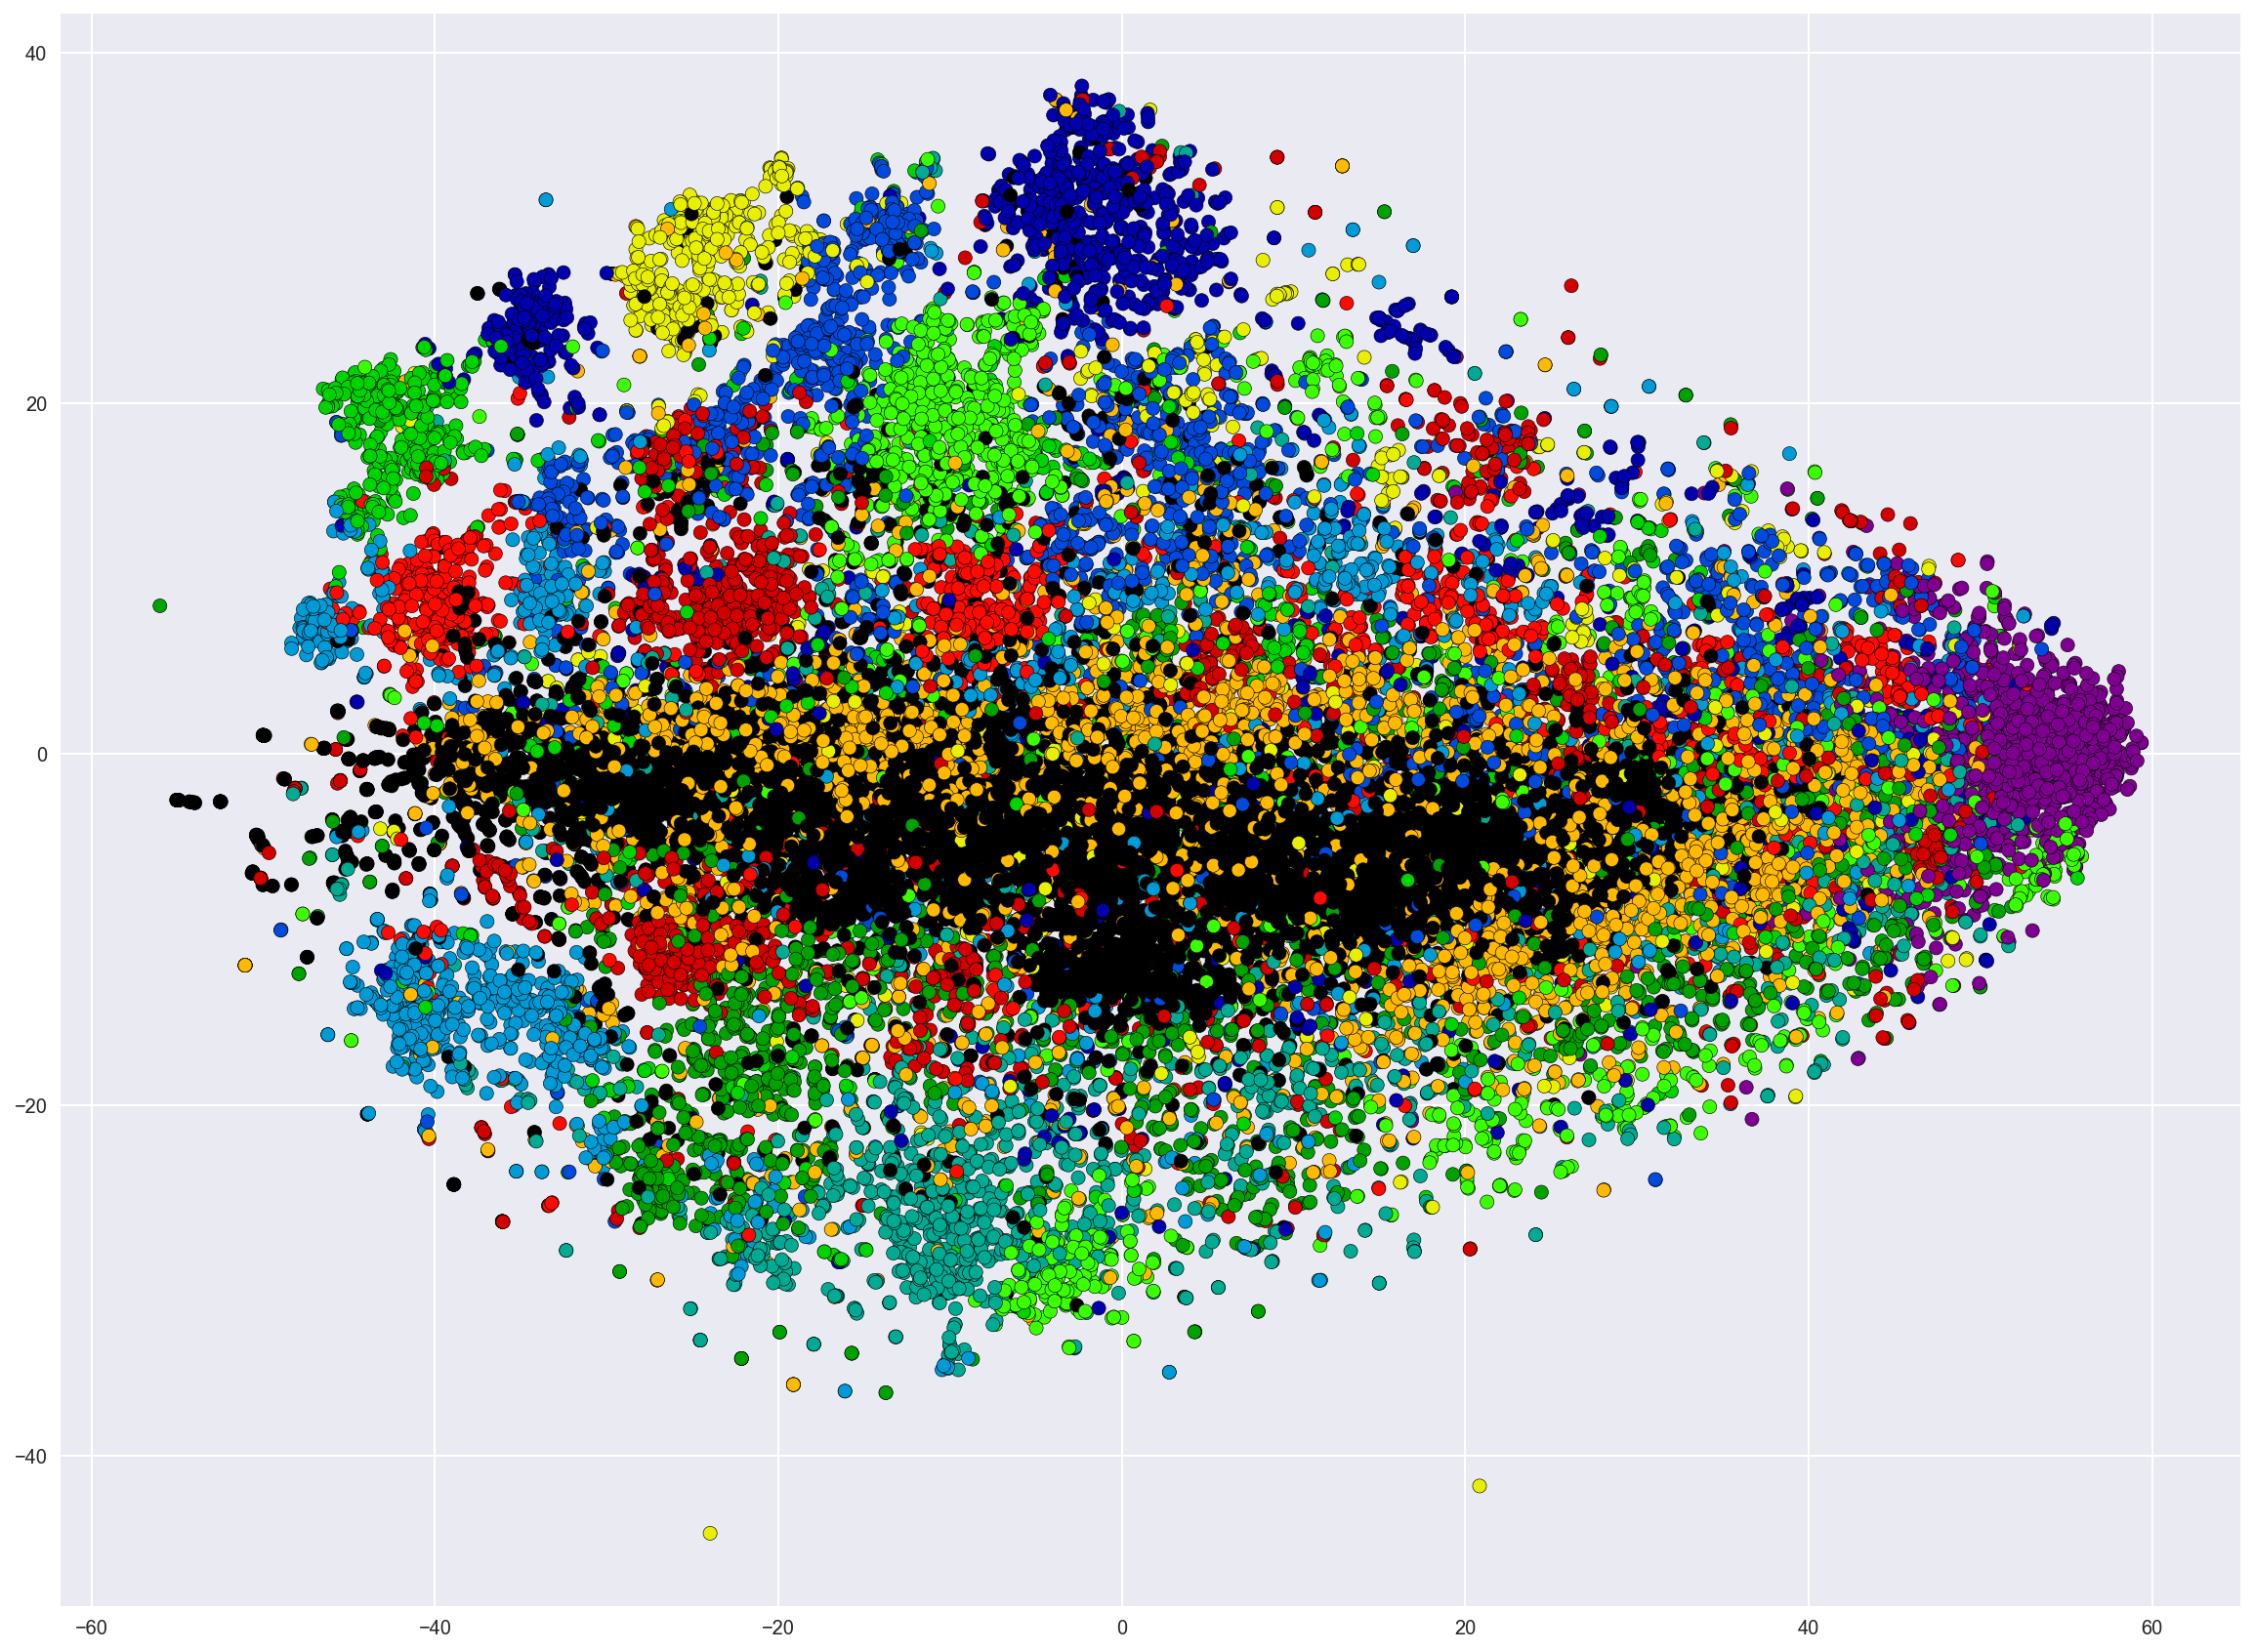

In [267]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1, 1, 1)
colors = cm.spectral(df_plot['cluster'].astype(float) / n_clusters)
ax.scatter(df_plot['x'], df_plot['y'], marker='.', c=colors, edgecolor='k', s=200)
plt.show()

## Bokeh

In [246]:
colors_hex = list(map(lambda x: '#%02x%02x%02x' % (x[0],x[1], x[2]), (colors*256).astype(int)))

In [250]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Div, BoxZoomTool, \
    ResetTool, PanTool, BoxSelectTool, LabelSet, WheelZoomTool, \
    BoxAnnotation, CustomJS, Toggle
from bokeh.layouts import layout as bl

output_file("doc2vec_jobs+profiles.html", title="Jobs and Profiles doc2vec")
source = ColumnDataSource(df_plot)

2017-11-23 21:57:54,379 : INFO : Session output file 'doc2vec_jobs+profiles.html' already exists, will be overwritten.


In [251]:
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("label", "@label"),
    ("headline", "@headline"),
    ("name", "@name"),
    ("description", "@description")
])

tools = [BoxZoomTool(), ResetTool(), PanTool(), BoxSelectTool(), WheelZoomTool()]

p = figure(plot_width=1200, plot_height=550, tools=[hover], title="Doc2vec - Jobs and Profiles")
for tool in tools:
    p.add_tools(tool)
p.circle('x', 'y', size=7, fill_color=colors_hex, source=source)

labels = LabelSet(x='x', y='y', text='headline', level='glyph', text_font_size="8pt",
              x_offset=1, y_offset=1, source=source, render_mode='canvas')
labels.visible = False

p.add_layout(labels)

code = '''\
if toggle.active
    labels.visible = true
    console.log 'enabling labels'
else
    labels.visible = false
    console.log 'disabling labels'
'''
callback = CustomJS.from_coffeescript(code=code, args={})
toggle = Toggle(label="Toggle labels", button_type="success", callback=callback)
callback.args = {'toggle': toggle, 'labels': labels}

layout = bl([p], [toggle])

show(layout)

C:\Users\RobertAlonso\Anaconda2\envs\or-tools\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


## Jobs vs Profiles

In [253]:
df_plot.head()

x         y  label                                     headline  \
0 -18.302687 -7.195676  Job-0                STEWARD - LAVADO DE VAJILLAS    
1 -38.999187 -6.381869  Job-1          Agente de Rentas Vitalicias - Lima    
2 -38.984230 -6.369105  Job-2     Agente de Rentas Vitalicias - CAJAMARCA    
3 -38.988728 -6.368634  Job-3      Agente de Rentas Vitalicias - TRUJILLO    
4 -25.134426  4.505952  Job-4  Coordinador de Planeamiento (Sede Central)    

                              name  \
0                              NaN   
1  INTERSEGURO COMPAÑÍA DE SEGUROS   
2  INTERSEGURO COMPAÑÍA DE SEGUROS   
3  INTERSEGURO COMPAÑÍA DE SEGUROS   
4                       zegel ipae   

                                         description  cluster  
0  Retail    Descripción  Importante cadena de re...        0  
1  Seguros/Previsión    Descripción  Agente\r\r\n...       12  
2  Seguros/Previsión    Descripción  Somos la Com...       12  
3  Seguros/Previsión    Descripción  Somos la Com...       12  
4  Educación    Descripción  Funciones: Elaborar ...       10

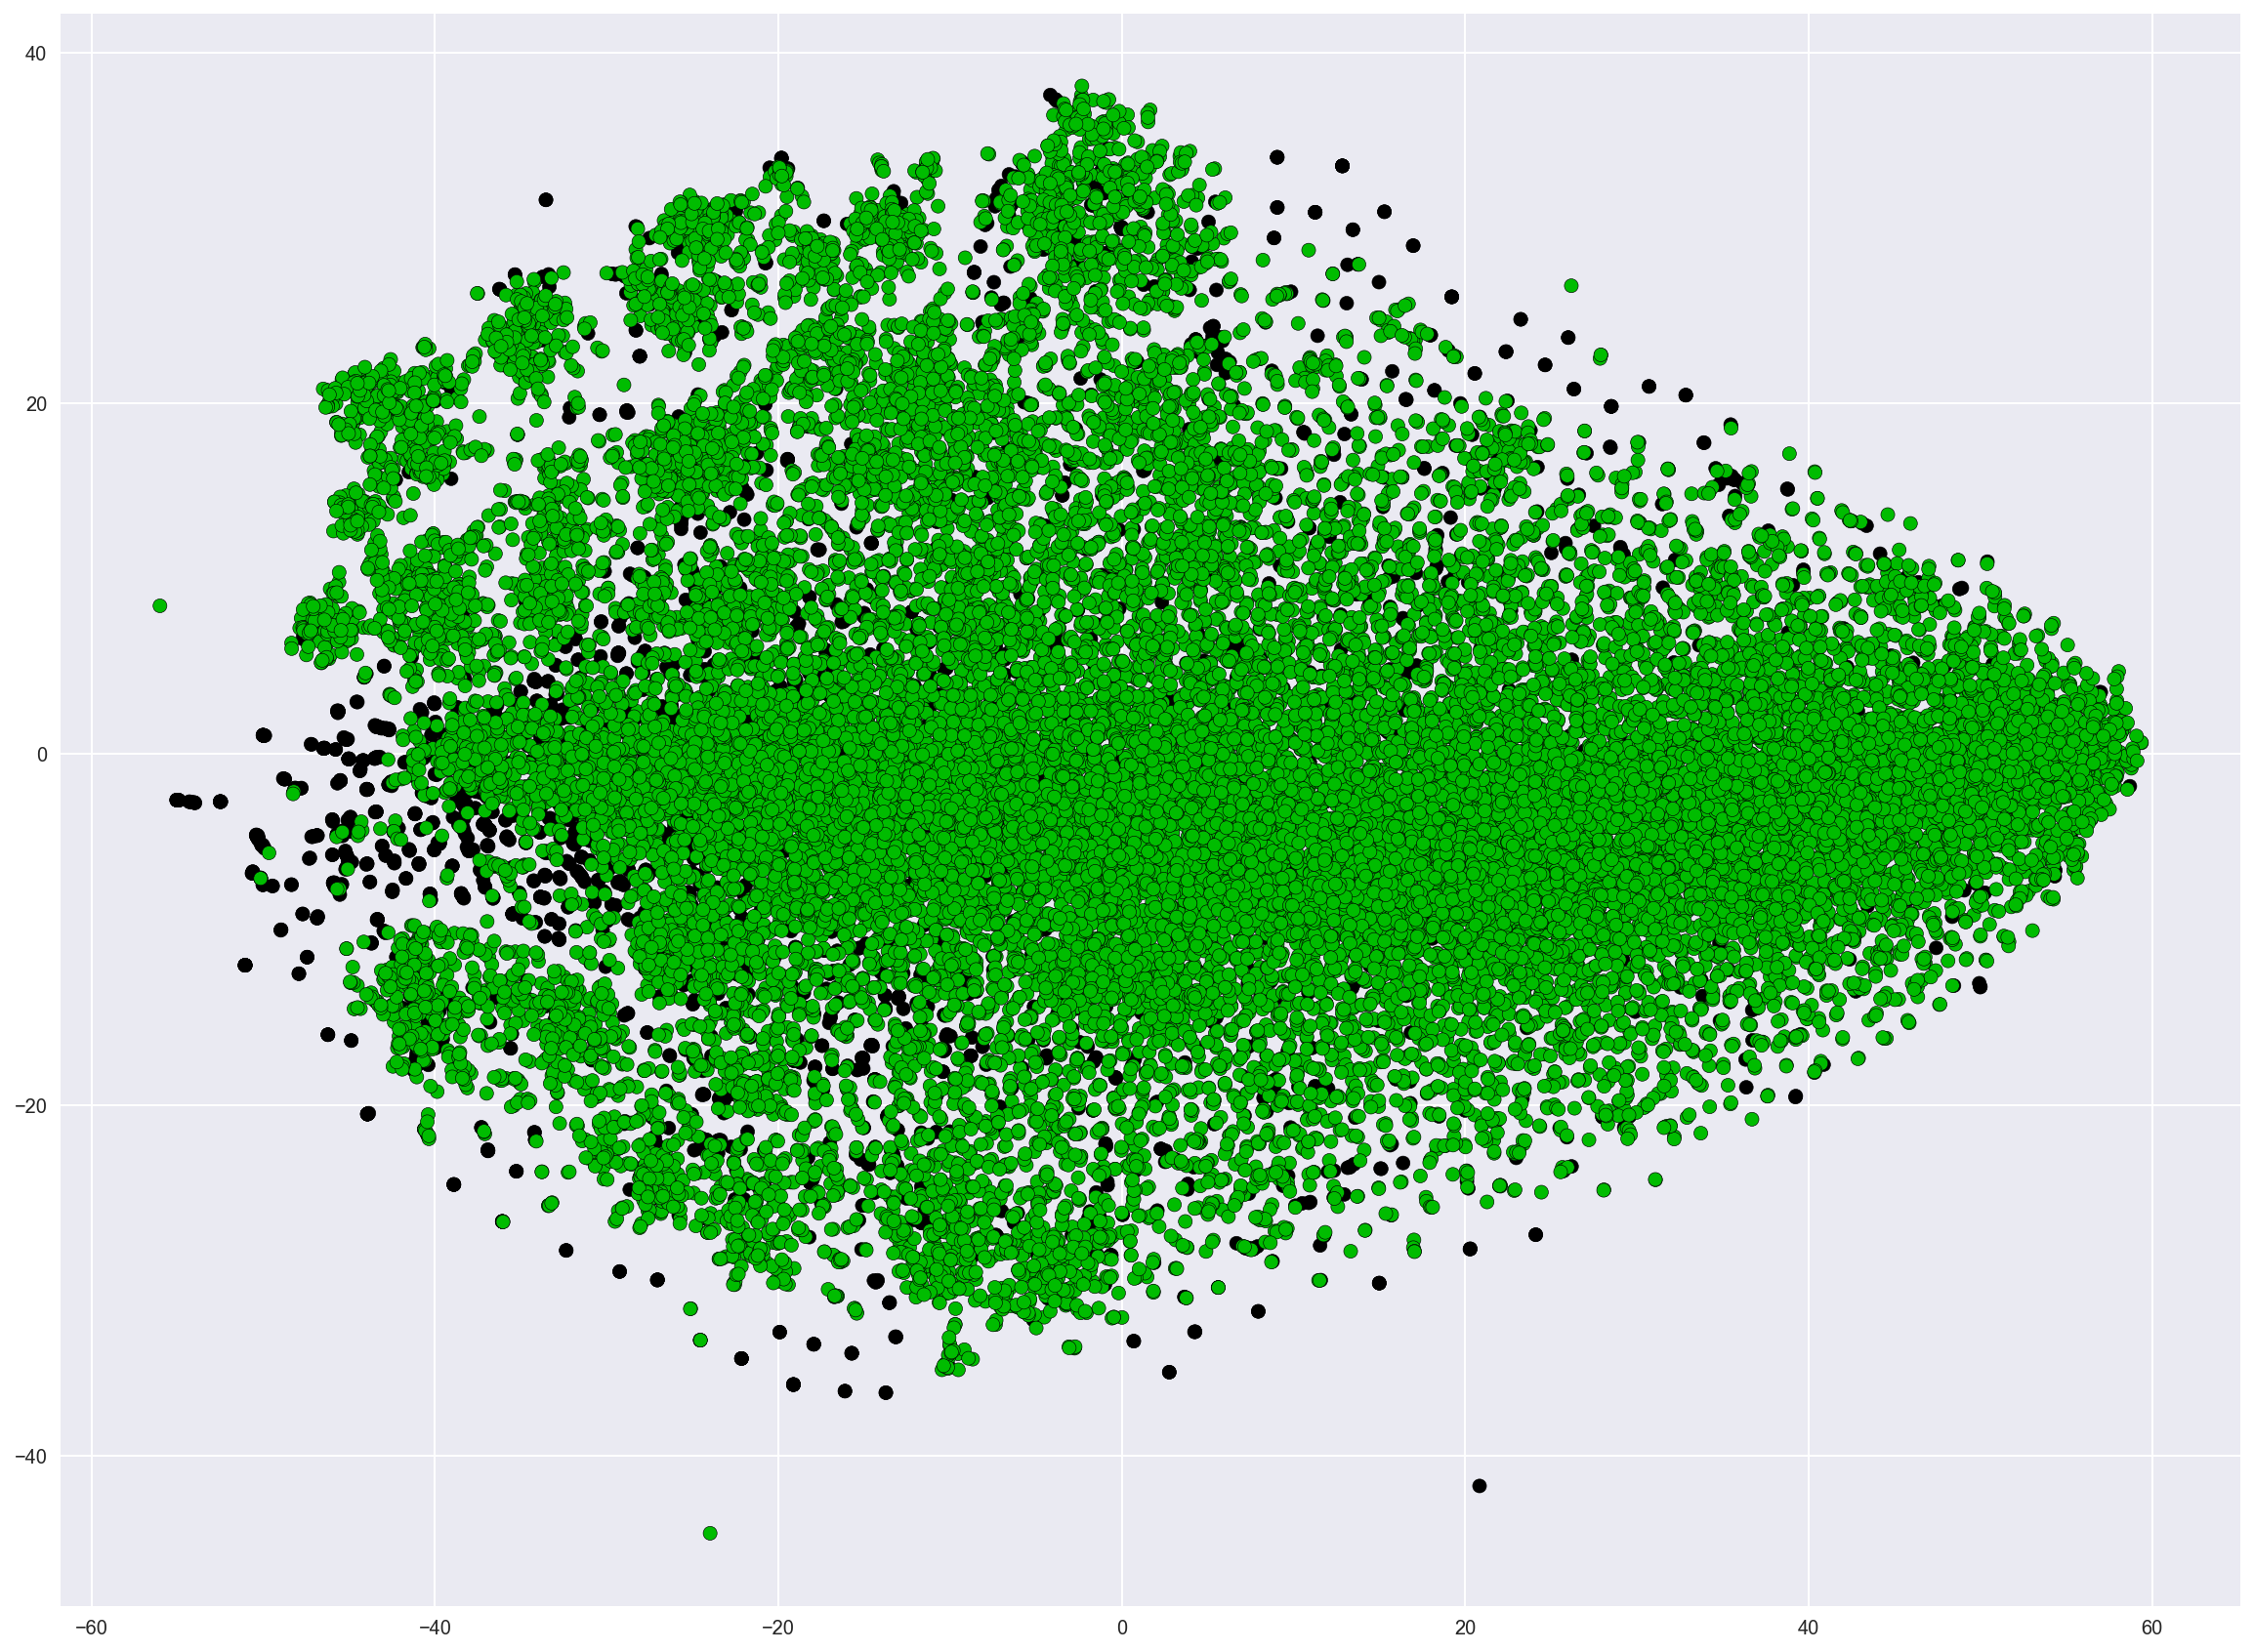

In [257]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1, 1, 1)
colors = cm.spectral(df_plot['label'].apply(lambda x: 0 if 'Job' in x else 1).astype(float) / 2)
ax.scatter(df_plot['x'], df_plot['y'], marker='.', c=colors, edgecolor='k', s=200)
plt.show()

## Vocabulary

In [27]:
df.head()

document  label
0  retail descripcion importante cadena restauran...  Job-0
1  seguros prevision descripcion agente rentas vi...  Job-1
2  seguros prevision descripcion compania seguros...  Job-2
3  seguros prevision descripcion compania seguros...  Job-3
4  educacion descripcion funciones elaborar prese...  Job-4

In [28]:
df['document'] = df['document'].apply(preprocess)

In [39]:
vocab = pd.Series([word for sentence in df['document'] for word in sentence.split()])

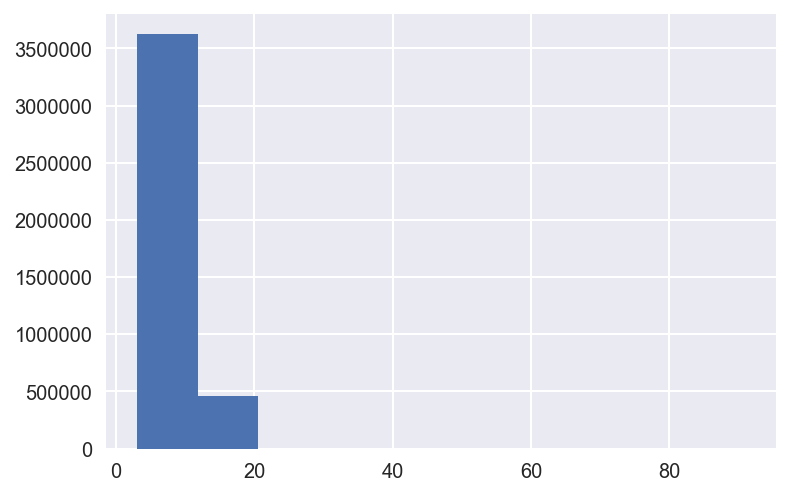

In [37]:
pd.Series(vocab).apply(len).hist()

In [41]:
vocab[vocab.apply(lambda x: len(x)>30)]

24608      desarrollarpermanentementegestioncomercialconc...
24651                        financieraycrediticiadeclientes
24652            elaborandopropuestadecreditosquemaximicenla
24656            analisiseinterpretaciondeestadosfinancieros
24657                   preparaciondememosdereconsideraciony
24660      manejodeinformacionparalosdealsforumnecesarios...
24683               recuperacionycobranzacuandoseapertinente
24685      seguimientoasucarteradeclientesconproductosact...
24686                 asegurandoquelosindicesdemorosidadsean
132365       requerimientosyreclamosdeclientesynoclientescon
148059           odocumentosvaloradosqueingresanosalendecaja
148082     promoverennuestrosclienteselusodemediosvirtual...
148084      alternativasdeatencionasusnecesidadesfinancieras
148085       aportandoalareducciondecostosyadisminuirlacarga
148088     participarenlaconsecuciondellogrodelasmetascom...
148300           odocumentosvaloradosqueingresanosalendecaja
148323     promoverennue

In [42]:
w2v_model = gensim.models.Word2Vec([sentence.split() for sentence in df['document']], window=5, size=100, sg=1, iter=20, min_count=30)

2017-11-24 02:29:43,983 : INFO : collecting all words and their counts
2017-11-24 02:29:43,984 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-11-24 02:29:44,529 : INFO : PROGRESS: at sentence #10000, processed 1529134 words, keeping 44971 word types
2017-11-24 02:29:44,903 : INFO : PROGRESS: at sentence #20000, processed 2857498 words, keeping 68799 word types
2017-11-24 02:29:45,254 : INFO : collected 85086 word types from a corpus of 4083374 raw words and 28785 sentences
2017-11-24 02:29:45,256 : INFO : Loading a fresh vocabulary
2017-11-24 02:29:45,985 : INFO : min_count=30 retains 9075 unique words (10% of original 85086, drops 76011)
2017-11-24 02:29:45,987 : INFO : min_count=30 leaves 3797557 word corpus (93% of original 4083374, drops 285817)
2017-11-24 02:29:46,029 : INFO : deleting the raw counts dictionary of 85086 items
2017-11-24 02:29:46,034 : INFO : sample=0.001 downsamples 47 most-common words
2017-11-24 02:29:46,036 : INFO : downsampling

2017-11-24 02:30:56,362 : INFO : PROGRESS: at 19.83% examples, 202872 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:30:57,364 : INFO : PROGRESS: at 20.05% examples, 202474 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:30:58,488 : INFO : PROGRESS: at 20.24% examples, 201845 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:30:59,529 : INFO : PROGRESS: at 20.44% examples, 201616 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:31:00,534 : INFO : PROGRESS: at 20.58% examples, 200609 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:31:01,564 : INFO : PROGRESS: at 20.73% examples, 199343 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:31:02,663 : INFO : PROGRESS: at 20.91% examples, 198161 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:31:03,799 : INFO : PROGRESS: at 21.10% examples, 196926 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:31:04,837 : INFO : PROGRESS: at 21.33% examples, 196402 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:31:05,842 : INFO : PROGRESS: at 21.64% examples, 196506 wor

2017-11-24 02:32:19,511 : INFO : PROGRESS: at 40.30% examples, 189088 words/s, in_qsize 5, out_qsize 0
2017-11-24 02:32:20,564 : INFO : PROGRESS: at 40.51% examples, 189106 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:21,602 : INFO : PROGRESS: at 40.76% examples, 189137 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:22,634 : INFO : PROGRESS: at 41.15% examples, 189593 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:23,640 : INFO : PROGRESS: at 41.54% examples, 190072 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:24,690 : INFO : PROGRESS: at 41.92% examples, 190491 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:25,713 : INFO : PROGRESS: at 42.18% examples, 190297 words/s, in_qsize 6, out_qsize 1
2017-11-24 02:32:26,715 : INFO : PROGRESS: at 42.45% examples, 190286 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:27,741 : INFO : PROGRESS: at 42.72% examples, 190184 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:32:28,761 : INFO : PROGRESS: at 43.00% examples, 190157 wor

2017-11-24 02:33:42,781 : INFO : PROGRESS: at 60.04% examples, 182121 words/s, in_qsize 5, out_qsize 0
2017-11-24 02:33:43,795 : INFO : PROGRESS: at 60.27% examples, 182265 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:44,852 : INFO : PROGRESS: at 60.57% examples, 182687 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:45,869 : INFO : PROGRESS: at 60.83% examples, 182700 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:46,955 : INFO : PROGRESS: at 61.12% examples, 182698 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:47,983 : INFO : PROGRESS: at 61.36% examples, 182596 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:49,112 : INFO : PROGRESS: at 61.55% examples, 182277 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:50,132 : INFO : PROGRESS: at 61.77% examples, 182151 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:51,172 : INFO : PROGRESS: at 61.97% examples, 181934 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:33:52,208 : INFO : PROGRESS: at 62.16% examples, 181660 wor

2017-11-24 02:35:06,734 : INFO : PROGRESS: at 76.77% examples, 172180 words/s, in_qsize 5, out_qsize 0
2017-11-24 02:35:07,781 : INFO : PROGRESS: at 77.01% examples, 172124 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:35:08,844 : INFO : PROGRESS: at 77.34% examples, 172225 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:35:09,865 : INFO : PROGRESS: at 77.65% examples, 172316 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:35:10,903 : INFO : PROGRESS: at 77.97% examples, 172424 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:35:11,919 : INFO : PROGRESS: at 78.27% examples, 172517 words/s, in_qsize 5, out_qsize 0
2017-11-24 02:35:13,053 : INFO : PROGRESS: at 78.52% examples, 172414 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:35:14,120 : INFO : PROGRESS: at 78.74% examples, 172325 words/s, in_qsize 5, out_qsize 0
2017-11-24 02:35:15,212 : INFO : PROGRESS: at 79.05% examples, 172404 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:35:16,321 : INFO : PROGRESS: at 79.23% examples, 172214 wor

2017-11-24 02:36:31,200 : INFO : PROGRESS: at 94.84% examples, 167978 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:36:32,225 : INFO : PROGRESS: at 95.09% examples, 168052 words/s, in_qsize 5, out_qsize 0
2017-11-24 02:36:33,318 : INFO : PROGRESS: at 95.31% examples, 168117 words/s, in_qsize 4, out_qsize 2
2017-11-24 02:36:34,457 : INFO : PROGRESS: at 95.53% examples, 168188 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:36:35,702 : INFO : PROGRESS: at 95.74% examples, 168057 words/s, in_qsize 6, out_qsize 1
2017-11-24 02:36:36,748 : INFO : PROGRESS: at 95.91% examples, 167922 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:36:37,769 : INFO : PROGRESS: at 96.10% examples, 167819 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:36:38,872 : INFO : PROGRESS: at 96.36% examples, 167807 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:36:39,898 : INFO : PROGRESS: at 96.66% examples, 167889 words/s, in_qsize 6, out_qsize 0
2017-11-24 02:36:40,925 : INFO : PROGRESS: at 96.96% examples, 167969 wor

In [85]:
w2v_model.save('Word2Vec_jobs+profiles')

2017-11-24 02:48:31,924 : INFO : saving Word2Vec object under Word2Vec_jobs+profiles, separately None
2017-11-24 02:48:31,927 : INFO : not storing attribute syn0norm
2017-11-24 02:48:31,929 : INFO : not storing attribute cum_table
2017-11-24 02:48:32,038 : INFO : saved Word2Vec_jobs+profiles


In [45]:
vocab = pd.Series(list(w2v_model.wv.vocab.keys()))

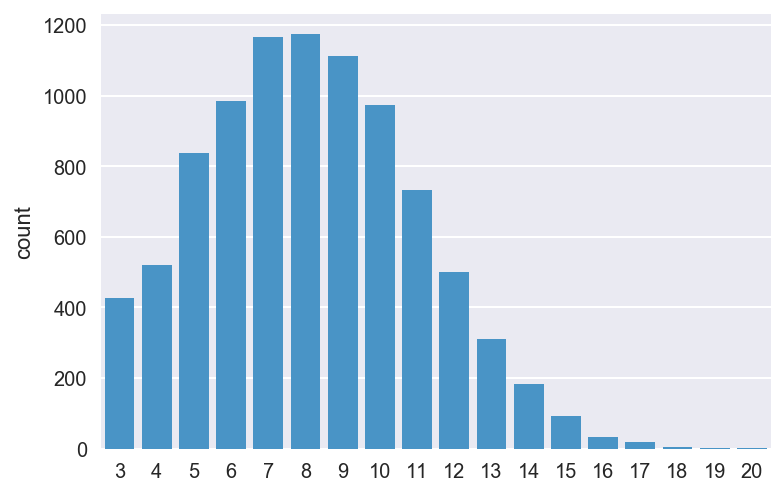

In [46]:
sns.countplot(x=vocab.apply(lambda x: len(x)), color="#3498db")

In [47]:
vocab.shape

(9075,)

In [58]:
w2v_model.most_similar('pucp')

[('pontificia', 0.7528402805328369),
 ('catolica', 0.7523089647293091),
 ('urp', 0.6444821357727051),
 ('universidad', 0.6279540061950684),
 ('esan', 0.5986874103546143),
 ('centrum', 0.5886287689208984),
 ('uni', 0.5861315727233887),
 ('unmsm', 0.5771670341491699),
 ('beca', 0.5561531186103821),
 ('politecnica', 0.5427963733673096)]

In [59]:
w2v_model.most_similar('bcp')

[('banco', 0.761125922203064),
 ('interbank', 0.6941316723823547),
 ('bbva', 0.6735960245132446),
 ('banbif', 0.6537267565727234),
 ('credito', 0.6101397275924683),
 ('continental', 0.6031366586685181),
 ('scotiabank', 0.601823091506958),
 ('citibank', 0.5586739778518677),
 ('mibanco', 0.5517727136611938),
 ('credicorp', 0.5423422455787659)]

In [61]:
w2v_model.most_similar('javascript')

[('css', 0.8779294490814209),
 ('jquery', 0.8718438744544983),
 ('ajax', 0.8545908331871033),
 ('mysql', 0.8457764983177185),
 ('javaserver', 0.8135310411453247),
 ('angularjs', 0.8128140568733215),
 ('json', 0.8103601932525635),
 ('sql', 0.8048512935638428),
 ('django', 0.7951861023902893),
 ('php', 0.7930886745452881)]

In [78]:
w2v_model.most_similar('contador')

[('contadora', 0.7716244459152222),
 ('contabilidad', 0.746338963508606),
 ('tributacion', 0.7175316214561462),
 ('cpc', 0.6883094310760498),
 ('accounting', 0.6830384731292725),
 ('finanzas', 0.680618166923523),
 ('publico', 0.664225161075592),
 ('colegiado', 0.6537861824035645),
 ('contable', 0.639319121837616),
 ('niif', 0.6301186084747314)]

In [79]:
w2v_model.most_similar('pucp')

[('pontificia', 0.7528402805328369),
 ('catolica', 0.7523089647293091),
 ('urp', 0.6444821357727051),
 ('universidad', 0.6279540061950684),
 ('esan', 0.5986874103546143),
 ('centrum', 0.5886287689208984),
 ('uni', 0.5861315727233887),
 ('unmsm', 0.5771670341491699),
 ('beca', 0.5561531186103821),
 ('politecnica', 0.5427963733673096)]

In [18]:
# vocab = vocab[vocab.apply(lambda x: len(x)<20 and len(x)>2)]

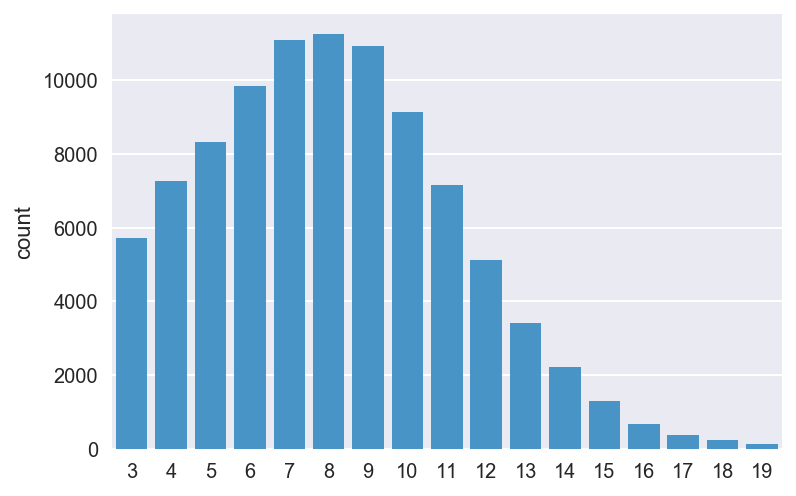

In [19]:
# sns.countplot(x=vocab.apply(lambda x: len(x)), color="#3498db")

In [23]:
model.most_similar('contador')

[('contabilidad', 0.6088201999664307),
 ('tributacion', 0.6051926016807556),
 ('ugel03', 0.5896072387695312),
 ('accounting', 0.5882482528686523),
 ('contadora', 0.5832140445709229),
 ('contabildiad', 0.579367458820343),
 ('finanzas', 0.5565799474716187),
 ('inquiry', 0.54623943567276),
 ('contaduria', 0.5444389581680298),
 ('cpc', 0.5387530326843262)]

## t-SNE

In [80]:
vocab.shape

(9075,)

(94127, 100)

In [81]:
X_words = model[vocab]

In [82]:
X_norm_words = X_words / np.reshape(np.linalg.norm(X_words, axis=1), (-1,1))

In [3]:
# X_norm_words = np.load('X_norm_words.npy')

In [87]:
# X_words_tsne = TSNE(n_components=2, verbose=10).fit_transform(X_norm_words)
# np.save('X_words_tsne', X_words_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9075 samples in 0.061s...
[t-SNE] Computed neighbors for 9075 samples in 20.834s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9075
[t-SNE] Computed conditional probabilities for sample 2000 / 9075
[t-SNE] Computed conditional probabilities for sample 3000 / 9075
[t-SNE] Computed conditional probabilities for sample 4000 / 9075
[t-SNE] Computed conditional probabilities for sample 5000 / 9075
[t-SNE] Computed conditional probabilities for sample 6000 / 9075
[t-SNE] Computed conditional probabilities for sample 7000 / 9075
[t-SNE] Computed conditional probabilities for sample 8000 / 9075
[t-SNE] Computed conditional probabilities for sample 9000 / 9075
[t-SNE] Computed conditional probabilities for sample 9075 / 9075
[t-SNE] Mean sigma: 0.299098
[t-SNE] Computed conditional probabilities in 0.408s
[t-SNE] Iteration 50: error = 95.7283096, gradient norm = 0.0000017 (50 iterations in 20.862s)
[t-SNE] Iteration 100

In [91]:
X_words_tsne = np.load('X_words_tsne.npy')

In [92]:
X_words_tsne.shape

(9075, 2)

## Kmeans

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
for k in range(10, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_norm_words)
    silhouette_avg = silhouette_score(X_norm_words, kmeans.labels_)
    print("For n_clusters =", k, "the average silhouette_score is :", silhouette_avg)

For n_clusters = 10 the average silhouette_score is : 0.0600351
For n_clusters = 11 the average silhouette_score is : 0.0600083
For n_clusters = 12 the average silhouette_score is : 0.0604587
For n_clusters = 13 the average silhouette_score is : 0.060384
For n_clusters = 14 the average silhouette_score is : 0.05858
For n_clusters = 15 the average silhouette_score is : 0.0506172
For n_clusters = 16 the average silhouette_score is : 0.0472615
For n_clusters = 17 the average silhouette_score is : 0.0444471
For n_clusters = 18 the average silhouette_score is : 0.058565
For n_clusters = 19 the average silhouette_score is : 0.0427856


In [95]:
n_clusters_words = 12
kmeans_words = KMeans(n_clusters=n_clusters_words, random_state=0).fit(X_norm_words)

In [96]:
df_plot_words = pd.concat([pd.DataFrame(X_words_tsne), pd.Series(vocab)], axis=1)
df_plot_words.columns = ['x', 'y', 'word']
df_plot_words['cluster'] = kmeans_words.labels_

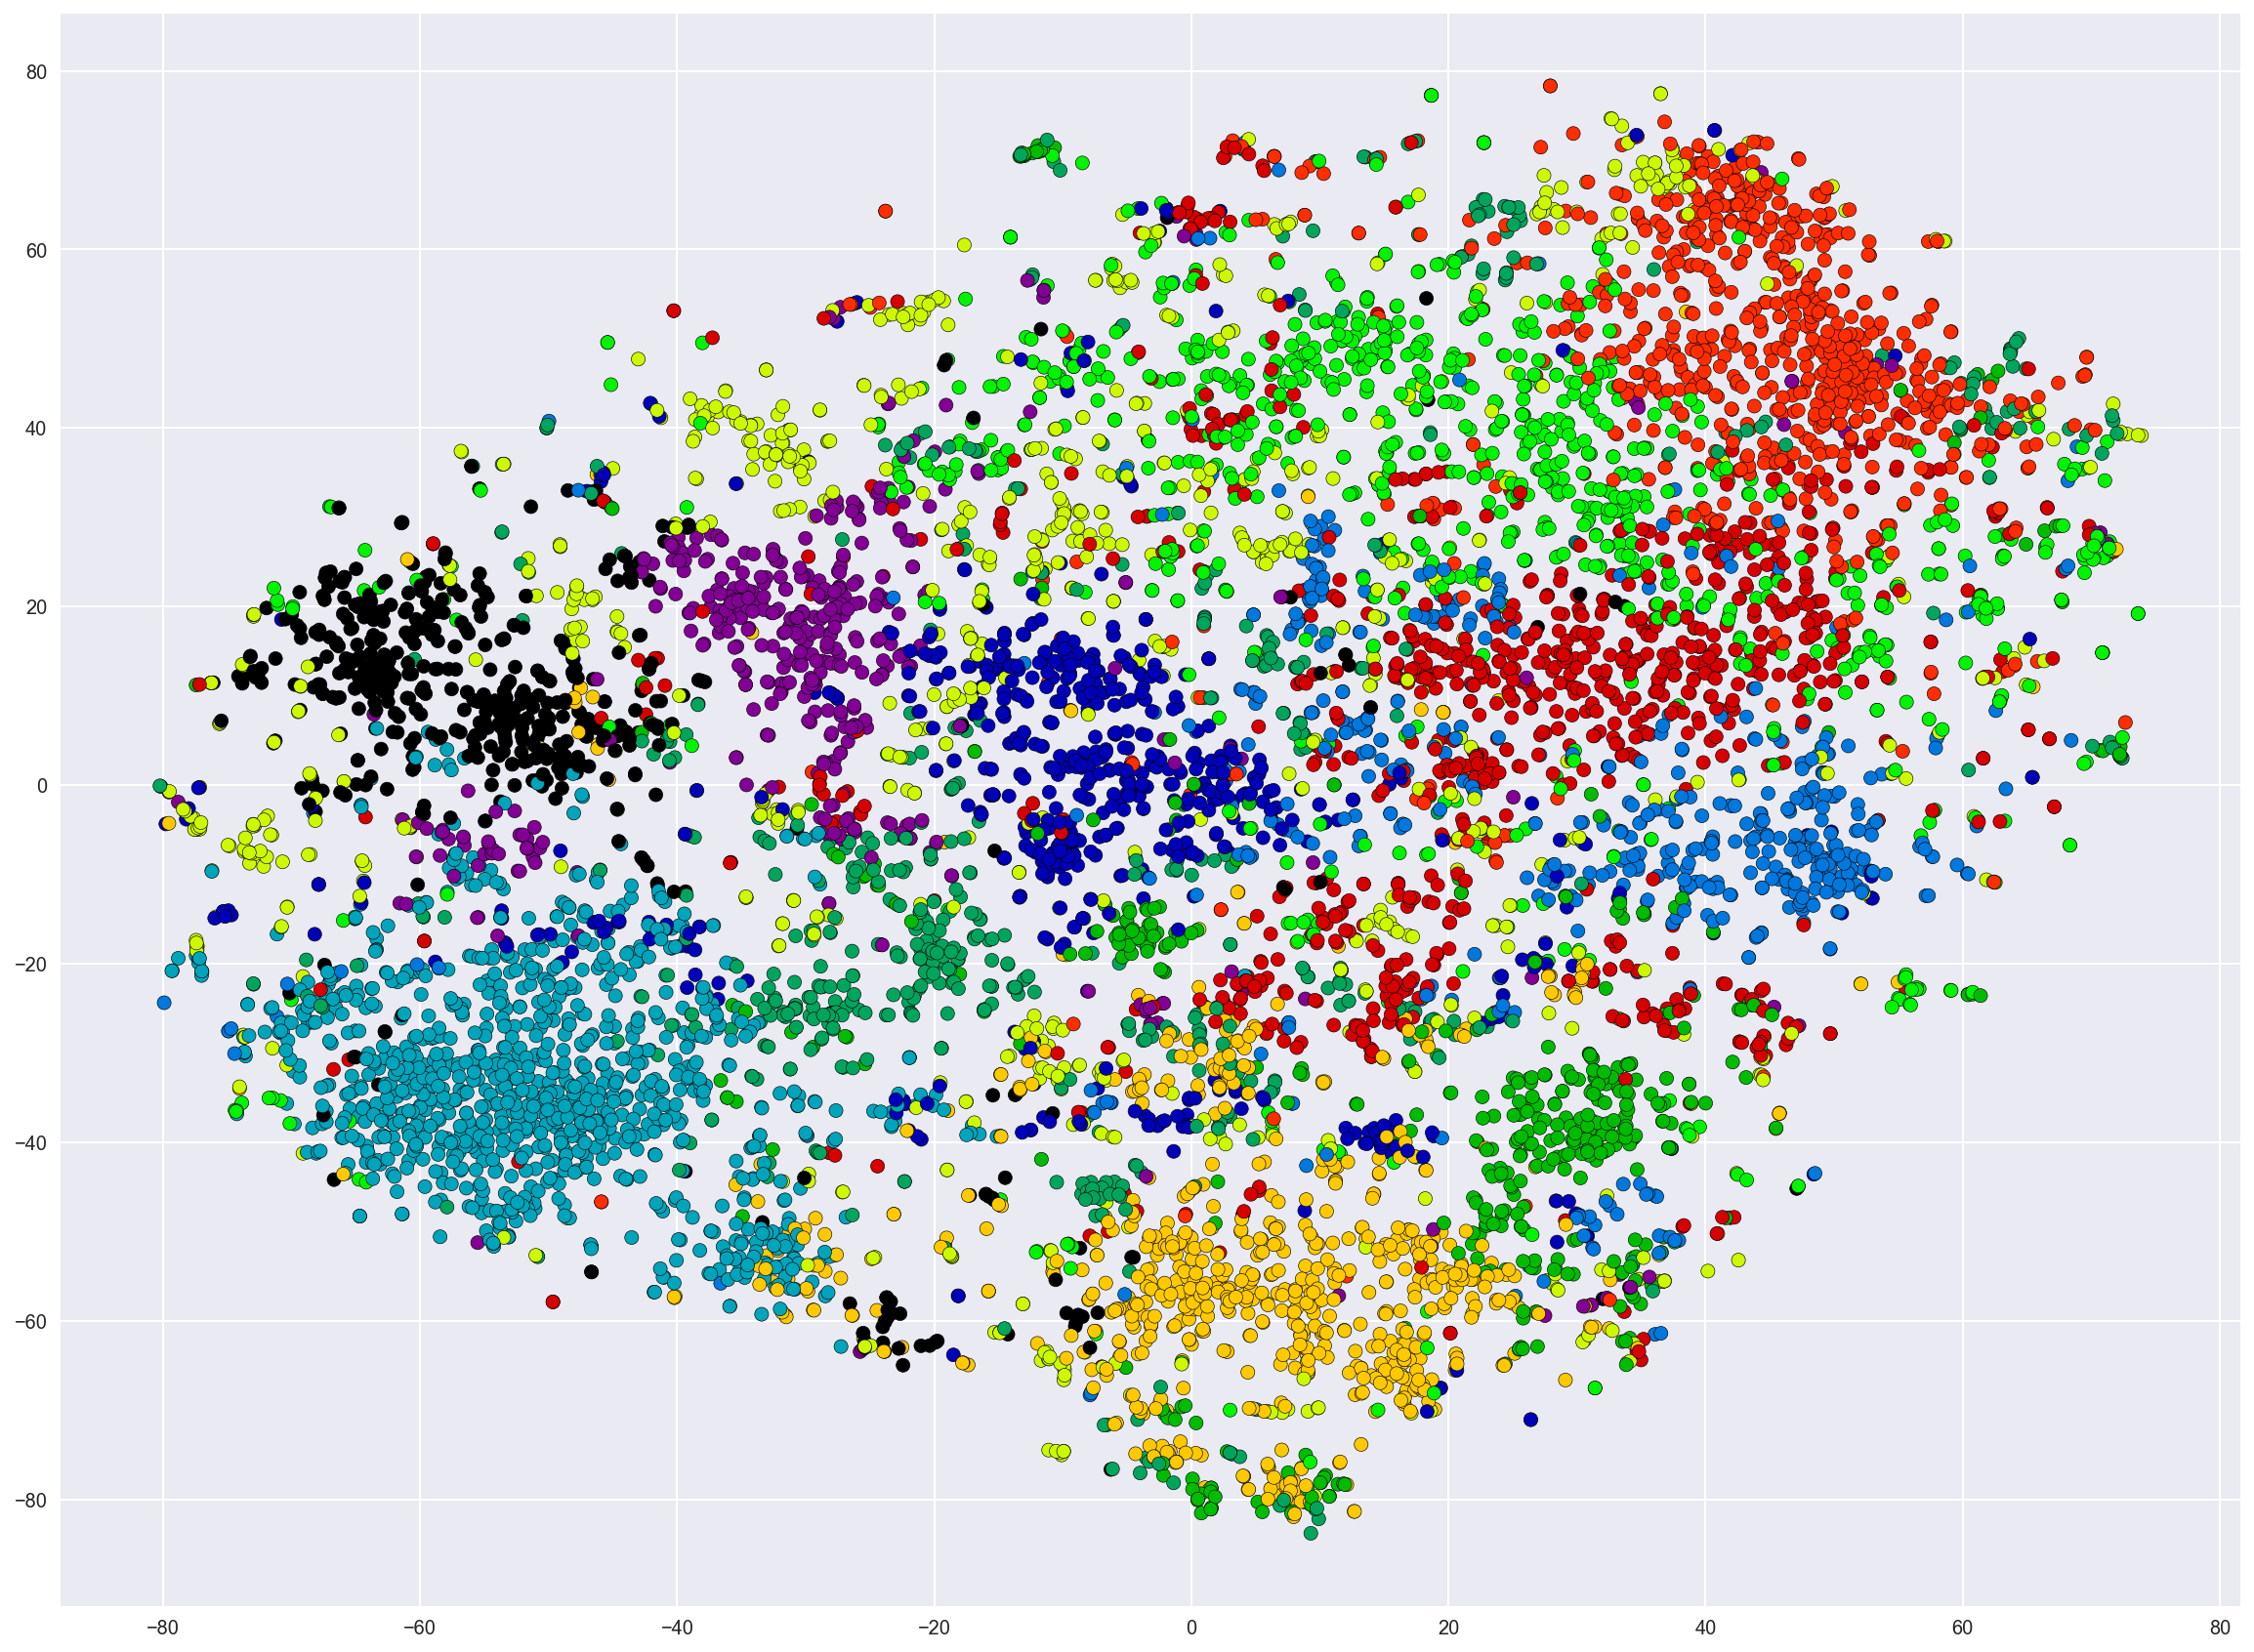

In [97]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(1, 1, 1)
colors_words = cm.spectral(df_plot_words['cluster'].astype(float) / n_clusters_words)
ax.scatter(df_plot_words['x'], df_plot_words['y'], marker='.', c=colors_words, edgecolor='k', s=200)
plt.show()

## Bokeh

In [98]:
colors_hex = list(map(lambda x: '#%02x%02x%02x' % (x[0],x[1], x[2]), (colors_words*256).astype(int)))

In [99]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Div, BoxZoomTool, \
    ResetTool, PanTool, BoxSelectTool, LabelSet, WheelZoomTool, \
    BoxAnnotation, CustomJS, Toggle
from bokeh.layouts import layout as bl

output_file("word2vec_jobs+profiles.html", title="Jobs and Profiles word2vec")
source = ColumnDataSource(df_plot_words)

In [100]:
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("word", "@word"),
])

tools = [BoxZoomTool(), ResetTool(), PanTool(), BoxSelectTool(), WheelZoomTool()]

p = figure(plot_width=1200, plot_height=550, tools=[hover], title="Word2vec - Jobs and Profiles")
for tool in tools:
    p.add_tools(tool)
p.circle('x', 'y', size=7, fill_color=colors_hex, source=source)

labels = LabelSet(x='x', y='y', text='word', level='glyph', text_font_size="8pt",
              x_offset=1, y_offset=1, source=source, render_mode='canvas')
labels.visible = False

p.add_layout(labels)

code = '''\
if toggle.active
    labels.visible = true
    console.log 'enabling labels'
else
    labels.visible = false
    console.log 'disabling labels'
'''
callback = CustomJS.from_coffeescript(code=code, args={})
toggle = Toggle(label="Toggle labels", button_type="success", callback=callback)
callback.args = {'toggle': toggle, 'labels': labels}

layout = bl([p], [toggle])

show(layout)

C:\Users\RobertAlonso\Anaconda2\envs\or-tools\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


## Lookup

In [101]:
df_plot_words.head()

x          y          word  cluster
0  50.274921 -14.174199      patentes        3
1  11.341529  51.929100     superando        7
2   7.836617 -35.643051  agropecuaria        2
3  31.137707  31.066151  determinando        7
4  42.299885  69.167267       palabra       10

In [102]:
df_plot_words[df_plot_words['word']=='economista']

x         y        word  cluster
6291  3.921956  27.72023  economista        8